DATASET RETIRADO DE https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Nesse notebook, vamos construir uma pipeline simples com o objetivo de realizar predições com um dado dataset.

# Pre-processing

In [8]:
df = pd.read_csv('star_classification.csv') # carrega nosso dataset
df.info() # informações básicas do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

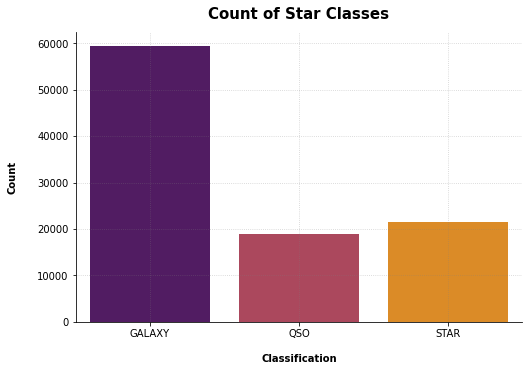

In [3]:
sns.catplot(x = 'class', kind = 'count', data = df, height=5.27, aspect=11.7/8.27, palette = 'inferno')
plt.xlabel("Classification", labelpad=15, fontweight = "bold", size = 10)
plt.ylabel("Count", labelpad=20, fontweight = "bold", size = 10)
plt.title("Count of Star Classes", y=1.025, fontweight = "bold", loc = 'center', size = 15)
plt.grid(linestyle = ':', color = 'gray', alpha = 0.4, zorder = 1)
plt.tight_layout()
plt.show()

Podemos perceber algumas coisas com o exposto acima:

* Não há dados faltantes no nosso dataset.
* Todos os dados são númericos (esses serão as features do nosso modelo), exceto pela coluna que informa a classe dos objetos analisados, que é categórica (e será a target a ser predita).

In [4]:
df.describe() # dados estatísticos básicos do dataframe

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


A partir da descrição acima, é razoável acreditar que não há nenhum dado distoante dentro do nosso dataframe. Considerando que ele foi fornecido pela própria NASA, a afirmação acima torna-se mais aceitável.

In [5]:
df.head() # visualização geral do dataframe

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [6]:
df['class'].unique() # visualização das categorias da target

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

Transformemos as categorias acima em números, para que possa ser feita a predição dos dados. 

In [9]:
# transformando nossa target em números com OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(df[['class']])
codes = ohe.transform(df[['class']]).toarray()
# pega o nome de cada class da target
feature_names = ohe.get_feature_names_out(['class'])
# junta os novos valores ao dataframe original
df = pd.concat([df.select_dtypes(exclude='object'),  pd.DataFrame(codes,columns=feature_names).astype(int)], axis=1)
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,class_GALAXY,class_QSO,class_STAR
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171,1,0,0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427,1,0,0
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299,1,0,0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775,1,0,0
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842,1,0,0


Dito tudo isso, não há mais necessidade de utilizar ferramentas de pré-processamento de dados. Podemos partir para a construção da pipeline e do nosso modelo.

# Train and test

In [11]:
# pega todas as colunas exceto class
X = df.drop(columns = ['class_GALAXY', 'class_QSO', 'class_STAR'])
# Class
y = df[['class_GALAXY', 'class_QSO', 'class_STAR']]

In [12]:
# divide o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

In [13]:
# constrói a pipeline com knn
pipe_knn = Pipeline([
('scaler', StandardScaler()), # escala os dados
('selector', VarianceThreshold()), # escolhe a melhor das features
('classifier', KNeighborsClassifier(n_neighbors = 3)) # modelo de classificação
])
# constrói a pipeline com árvore de decisão
pipe_tree = Pipeline([
('scaler', StandardScaler()), # escala os dados
('selector', VarianceThreshold()), # escolhe a melhor das features
('classifier', DecisionTreeClassifier(max_depth=7)) # modelo de classificação
])
# constrói a pipeline com Random Forest
pipe_random = Pipeline([
('scaler', StandardScaler()), # escala os dados
('selector', VarianceThreshold()), # escolhe a melhor das features
('classifier', RandomForestClassifier()) # modelo de classificação
])

In [14]:
# fita o modelo knn
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [15]:
# fita o modelo de Árvore de Decisão
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('classifier', DecisionTreeClassifier(max_depth=7))])

In [16]:
# fita o modelo de Random Forest
pipe_random.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('classifier', RandomForestClassifier())])

In [17]:
# predição do knn
y_pred_knn = pipe_knn.predict(X_test)

In [18]:
# a predição da Árvore de Decisão
y_pred_tree = pipe_tree.predict(X_test)

In [19]:
# a predição do Random Forest
y_pred_random = pipe_random.predict(X_test)

# Evaluation

## Knn

In [20]:
# printa a matriz de confusão e o relatório de classificação
print(f'Confusion matrix: \n {confusion_matrix(y_test.values.argmax(axis=1), y_pred_knn.argmax(axis=1))}\n')
print(f'Classification report: \n {classification_report(y_test.values.argmax(axis=1), y_pred_knn.argmax(axis=1))}')

Confusion matrix: 
 [[17096   189   549]
 [  943  4672    73]
 [ 1281    14  5183]]

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     17834
           1       0.96      0.82      0.88      5688
           2       0.89      0.80      0.84      6478

    accuracy                           0.90     30000
   macro avg       0.91      0.86      0.88     30000
weighted avg       0.90      0.90      0.90     30000



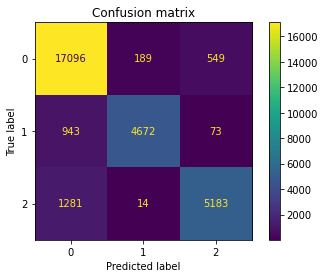

In [22]:
# plotando a matriz de confusão acima
ConfusionMatrixDisplay(confusion_matrix(y_test.values.argmax(axis=1), y_pred_knn.argmax(axis=1))).plot()
plt.title('Confusion matrix')
plt.show()

## Árvore de decisão

In [23]:
# printa a matriz de confusão e o relatório de classificação
print(f'Confusion matrix: \n {confusion_matrix(y_test.values.argmax(axis=1), y_pred_tree.argmax(axis=1))}\n')
print(f'Classification report: \n {classification_report(y_test.values.argmax(axis=1), y_pred_tree.argmax(axis=1))}')

Confusion matrix: 
 [[17625   187    22]
 [  557  5131     0]
 [   22     0  6456]]

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     17834
           1       0.96      0.90      0.93      5688
           2       1.00      1.00      1.00      6478

    accuracy                           0.97     30000
   macro avg       0.98      0.96      0.97     30000
weighted avg       0.97      0.97      0.97     30000



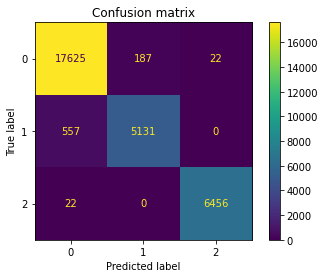

In [25]:
# plotando a matriz de confusão acima
ConfusionMatrixDisplay(confusion_matrix(y_test.values.argmax(axis=1), y_pred_tree.argmax(axis=1))).plot()
plt.title('Confusion matrix')
plt.show()

## Random Forest

In [31]:
# printa a matriz de confusão e o relatório de classificação
print(f'Confusion matrix: \n {confusion_matrix(y_test.values.argmax(axis=1), y_pred_random.argmax(axis=1))}\n')
print(f'Classification report: \n {classification_report(y_test.values.argmax(axis=1), y_pred_random.argmax(axis=1))}')

Confusion matrix: 
 [[17625   170    39]
 [  449  5239     0]
 [    8     0  6470]]

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     17834
           1       0.97      0.92      0.94      5688
           2       0.99      1.00      1.00      6478

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



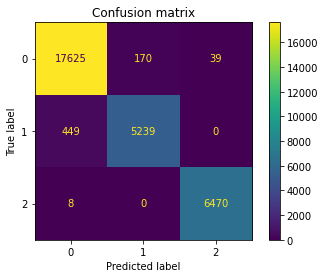

In [32]:
# plotando a matriz de confusão acima
ConfusionMatrixDisplay(confusion_matrix(y_test.values.argmax(axis=1), y_pred_random.argmax(axis=1))).plot()
plt.title('Confusion matrix')
plt.show()